In [1]:
import pandas as pd
import os
pd.set_option('display.max_colwidth', None)

# this radar_factory is provided by matplotlib https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html
# we will use this to present our compatibilities and skill scores
import radar_factory as rf
import matplotlib.pyplot as plt

import numpy as np
rng = np.random.default_rng() # For testing


Welcome to the prototype! Let's figure stuff out.

In [2]:
# File names and extensions setup. As each file has multiple sheets, we need to track those too.
# If we're using them. We might not, but for now just have the major files.
# header = 1 so we have the titles conveniently, as the first row is the sheet title.

# Aggregate economy
doc_agg19 = pd.read_excel("project_data/2019-29/aggregate-economy-tables.xlsx", sheet_name=None, header = 0)
doc_agg23 = pd.read_excel("project_data/2023-33/aggregate-economy-tables.xlsx", sheet_name=None, header = 0)

# Education
doc_edu19 = pd.read_excel("project_data/2019-29/education.xlsx", sheet_name=None, header = 1)
doc_edu23 = pd.read_excel("project_data/2023-33/education.xlsx", sheet_name=None, header = 1)

# industry
doc_ind19 = pd.read_excel("project_data/2019-29/industry.xlsx", sheet_name=None, header = 1)
doc_ind23 = pd.read_excel("project_data/2023-33/industry.xlsx", sheet_name=None, header = 1)

# labor force
doc_lab19 = pd.read_excel("project_data/2019-29/labor-force.xlsx", sheet_name=None, header = 1)
doc_lab23 = pd.read_excel("project_data/2023-33/labor-force.xlsx", sheet_name=None, header = 1)

# occupation
doc_occ19 = pd.read_excel("project_data/2019-29/occupation.xlsx", sheet_name=None, header = 1)
doc_occ23 = pd.read_excel("project_data/2023-33/occupation.xlsx", sheet_name=None, header = 1)

# skills (just 2023)
skills = pd.read_excel("project_data/2023-33/skills.xlsx", sheet_name=None, header = 1)

In [3]:
# File checking. Still need to do cleanup, but working on it.
sheet_names = list(skills.keys())  # Convert keys to a list
sheet_cats = skills[sheet_names[0]]  # Access the sheets
sheet_cats.head(4)  # Display the first few rows

,Table 6.1 Skills data by major occupational group
0,Table 6.2 Skills data by detailed occupation
1,Table 6.3 Top skills categories for fastest growing occupations
2,Table 6.4 Skills data by typical education needed for entry
3,Table 6.5 Percentile rank of detailed occupations by skills category


In [4]:
# Data by major occupational group
data_by_occ = skills[sheet_names[1]]

In [5]:
data_by_occ.head(1)

,2023 National Employment Matrix title,2023 National Employment Matrix code,"Employment, 2023","Employment, 2033","Employment change, numeric, 2023–33","Employment change, percent, 2023–33",Adaptability,Computers and information technology,Creativity and innovation,Critical and analytical thinking,...,Interpersonal,Leadership,Mathematics,Mechanical,Physical strength and stamina,Problem solving and decision making,Project management,Science,Speaking and listening,Writing and reading
0,"Total, all occupations",00-0000,167849.8,174589.0,6739.2,4.0,3.8,3.0,2.7,3.1,...,3.5,3.2,2.6,1.9,2.2,3.5,2.7,1.7,3.2,3.3


In [6]:
# Truncate columns [1 to 5]
data_by_occ = data_by_occ.iloc[:, [0] + list(range(6, data_by_occ.shape[1]))]

# Now left with jobs and skills. Each skill is scored from 1 to 5, least important to extremely important.
# We use these values as a positive multiplier for the final score.

data_by_occ.head()

,2023 National Employment Matrix title,Adaptability,Computers and information technology,Creativity and innovation,Critical and analytical thinking,Customer service,Detail oriented,Fine motor,Interpersonal,Leadership,Mathematics,Mechanical,Physical strength and stamina,Problem solving and decision making,Project management,Science,Speaking and listening,Writing and reading
0,"Total, all occupations",3.8,3.0,2.7,3.1,3.3,3.6,2.5,3.5,3.2,2.6,1.9,2.2,3.5,2.7,1.7,3.2,3.3
1,Management occupations,4.1,3.5,3.0,3.6,3.5,3.6,1.9,3.7,4.0,3.1,1.7,1.7,4.0,3.5,1.7,3.6,3.8
2,Business and financial operations occupations,4.0,3.7,2.8,3.7,3.3,3.6,1.7,3.5,3.4,3.2,1.3,1.3,3.8,3.1,1.4,3.6,3.9
3,Computer and mathematical occupations,3.9,4.3,3.1,3.9,2.6,3.7,2.2,3.1,3.1,3.1,1.9,1.3,3.8,2.7,1.7,3.4,3.8
4,Architecture and engineering occupations,3.8,3.8,3.1,3.8,2.7,3.8,2.2,3.0,3.2,3.6,2.1,1.5,3.8,2.9,2.6,3.3,3.7


Let's get a prototype going to show what we want to do. We essentially want to rate a person's compatibility to an industry based on their skills, and we want to visualize this nicely in some kind of final product. 

In [7]:
# Pulling all the skills
skill_names = data_by_occ.columns[1:].tolist()
skill_names[:4]

['Adaptability',
 'Computers and information technology',
 'Creativity and innovation',
 'Critical and analytical thinking']

In [8]:
# Pulling all the major job categories names
# Truncate combined data and ending notes.
group_names = data_by_occ.iloc[1:-4, 0].tolist()
group_names[:4]


['  Management occupations',
 '  Business and financial operations occupations',
 '  Computer and mathematical occupations',
 '  Architecture and engineering occupations']

In [9]:
data_by_occ.columns[0]

'2023 National Employment Matrix title'

In [12]:
test = data_by_occ[data_by_occ[data_by_occ.columns[0]].str.contains(group_names[0])]
test.iloc[0].tolist()
#test.iloc[0].tolist()[1]

['  Management occupations',
 4.1,
 3.5,
 3.0,
 3.6,
 3.5,
 3.6,
 1.9,
 3.7,
 4.0,
 3.1,
 1.7,
 1.7,
 4.0,
 3.5,
 1.7,
 3.6,
 3.8]

These are the major skills we are working with and are looking to evaluate from the questions. For now, we'll randomly generate the skills for a person, essentially generating a random person that took our quiz!

What is most important is that we will be using the data from the skills sheet to provide a strong weight for a person's individual characteristics, allowing us to provide an accurate score for their compatibility to an industry or even job. For now, we're focusing on the major, categorical parts of the job.

In [ ]:
import asyncio
import websockets
import nest_asyncio
import json
from IPython import get_ipython

# Allow nested event loops in Jupyter Notebook
nest_asyncio.apply()

# Initialize a global variable for person scores
person_scores = None  # This will hold the extracted ratings from the JSON



# WebSocket listener function
async def websocket_client():
    uri = "ws://localhost:3000"  # WebSocket server URL
    try:
        async with websockets.connect(uri) as websocket:
            print("Connected to WebSocket server. Listening for messages...")
            
            while True:
                # Wait for a message from the server
                response = await websocket.recv()
                print(f"Message received from server: {response}")
                
                # Parse JSON response and extract ratings
                global person
                try:
                    data = json.loads(response)  # Parse the JSON string
                    # Generating a random person with certain skill affinities from 0 to 1
                    # Not yet taking into account the degree yet. That's a bit finicky, and we have to think about
                    # the implications of the value of a degree first. Some jobs value higher degrees whereas others
                    # don't care.
                    person = [entry['rating']/10 for entry in data]  # Extract ratings
                    print(f"Updated person: {person}")
                    person_scores = np.round(np.zeros(len(group_names)), 2)

                    for i in range(len(group_names)):
                        row = data_by_occ[data_by_occ[data_by_occ.columns[0]].str.contains(group_names[i])]
                        skillweight = row.iloc[0].tolist()
                        # For each skill
                        for j in range(len(skill_names)):
                            score = person[j] * skillweight[j + 1] * 20
                            person_scores[i] += score          


                    perfect_scores = np.zeros(len(group_names))

                    for i in range(len(group_names)):
                        row = data_by_occ[data_by_occ[data_by_occ.columns[0]].str.contains(group_names[i])]
                        skillweight = row.iloc[0].tolist()
                        # For each skill
                        for j in range(len(skill_names)):
                            score = 1 * skillweight[j + 1] * 20
                            perfect_scores[i] += score
        

                    final_scores = np.zeros(len(group_names))
                    for i in range(len(final_scores)):
                        final_scores[i] = person_scores[i]/perfect_scores[i]
                    final_scores  
                    
                    final_scores_json = json.dumps({"final_scores": final_scores.tolist()})  # Convert to JSON
                    await websocket.send(final_scores_json)
                    print(f"Final scores sent to server: {final_scores}")
                        # n = len(group_names)  # Number of axes
                        # theta = rf.radar_factory(n, frame='polygon')  # Generate the angles

                        # # Create a figure and axis
                        # fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': 'radar'})
                        # ax.set_title("Your Industry Proficiency!", weight='bold', size='large', position=(0.5, 1.1))

                        # # Plot the data
                        # ax.plot(theta, final_scores, color='g', linewidth=2, label='Skill Proficiency')
                        # ax.fill(theta, final_scores, color='g', alpha=0.25)

                        # # Set axis labels and limits
                        # ax.set_varlabels(group_names)
                        # ax.set_ylim(0, 1)  # Set the max value of each axis to 1

                        # # Add a legend
                        # ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))

                        # # Display the chart
                        # plt.show()  

                except (json.JSONDecodeError, KeyError, TypeError) as e:
                    print(f"Error parsing response: {e}. Expected a JSON array with 'question' and 'rating' fields.")
                    continue

    except Exception as e:
        print(f"Error: {e}")

# Start the WebSocket client
await websocket_client()


Connected to WebSocket server. Listening for messages...
Message received from server: [{"question":"How confident are you in your ability to solve challenging problems independently?","rating":6},{"question":"How motivating do you find a fast-paced work environment?","rating":5},{"question":"How well do you manage your time when you have multiple tasks to complete?","rating":8},{"question":"How effectively do you handle stress or tight deadlines?","rating":9},{"question":"How comfortable are you with roles that require public speaking or regular interaction with new people?","rating":10},{"question":"How rewarding do you find hands-on tasks or creative projects?","rating":0},{"question":"How comfortable are you with receiving detailed instructions and feedback?","rating":0},{"question":"How motivated are you by recognition in a professional setting?","rating":4},{"question":"How easily do you adapt to unexpected changes in your work schedule or plans?","rating":6},{"question":"How int

In [20]:
arr =  [0.17, 0.27, 0.31, 0.87, 0.16, 0.19, 0.45, 0.88, 0.65, 0.34, 0.94,
       0.87, 0.79, 0.12, 0.4 , 0.07, 0.39]
len(arr)

17

In [13]:
# Generating a random person with certain skill affinities from 0 to 1
# Not yet taking into account the degree yet. That's a bit finicky, and we have to think about
# the implications of the value of a degree first. Some jobs value higher degrees whereas others
# don't care.
person = np.round(np.random.rand(len(skill_names)), 2)
person_scores = np.round(np.zeros(len(group_names)), 2)
person

array([0.17, 0.27, 0.31, 0.87, 0.16, 0.19, 0.45, 0.88, 0.65, 0.34, 0.94,
       0.87, 0.79, 0.12, 0.4 , 0.07, 0.39])

In [14]:
# Scoring a person into each major occupation
# Take skill * weight * 20. That's their weighted score for one skill.
# At worst, we get 0. At best, we get 100. We will aggregate these scores later.

# For each job
for i in range(len(group_names)):
    row = data_by_occ[data_by_occ[data_by_occ.columns[0]].str.contains(group_names[i])]
    skillweight = row.iloc[0].tolist()
    # For each skill
    for j in range(len(skill_names)):
        score = person[j] * skillweight[j + 1] * 20
        person_scores[i] += score

In [15]:
person_scores

array([475.68, 443.62, 454.54, 467.4 , 467.22, 453.4 , 428.98, 452.38,
       434.24, 500.12, 453.7 , 478.54, 410.7 , 412.8 , 423.58, 425.6 ,
       408.  , 446.44, 470.76, 489.28, 439.36, 424.92])

This is a person's ratings for each job industry. At a first glance, we're assuming the higher the better, since the most important skills carry the most weight.

In [17]:
group_names

['  Management occupations',
 '  Business and financial operations occupations',
 '  Computer and mathematical occupations',
 '  Architecture and engineering occupations',
 '  Life, physical, and social science occupations',
 '  Community and social service occupations',
 '  Legal occupations',
 '  Educational instruction and library occupations',
 '  Arts, design, entertainment, sports, and media occupations',
 '  Healthcare practitioners and technical occupations',
 '  Healthcare support occupations',
 '  Protective service occupations',
 '  Food preparation and serving related occupations',
 '  Building and grounds cleaning and maintenance occupations',
 '  Personal care and service occupations',
 '  Sales and related occupations',
 '  Office and administrative support occupations',
 '  Farming, fishing, and forestry occupations',
 '  Construction and extraction occupations',
 '  Installation, maintenance, and repair occupations',
 '  Production occupations',
 '  Transportation and 

In [16]:
perfect_scores = np.zeros(len(group_names))

for i in range(len(group_names)):
    row = data_by_occ[data_by_occ[data_by_occ.columns[0]].str.contains(group_names[i])]
    skillweight = row.iloc[0].tolist()
    # For each skill
    for j in range(len(skill_names)):
        score = 1 * skillweight[j + 1] * 20
        perfect_scores[i] += score
perfect_scores

array([1080., 1026., 1032., 1058., 1056., 1030., 1002., 1036.,  994.,
       1112.,  996., 1060.,  914.,  884.,  942.,  972.,  946.,  946.,
       1004., 1036.,  942.,  918.])

In [17]:
final_scores = np.zeros(len(group_names))
for i in range(len(final_scores)):
    final_scores[i] = person_scores[i]/perfect_scores[i]
final_scores

array([0.44044444, 0.43237817, 0.44044574, 0.44177694, 0.44244318,
       0.44019417, 0.42812375, 0.43666023, 0.43686117, 0.4497482 ,
       0.45552209, 0.45145283, 0.44934354, 0.46696833, 0.4496603 ,
       0.43786008, 0.43128964, 0.47192389, 0.46888446, 0.47227799,
       0.46641189, 0.46287582])

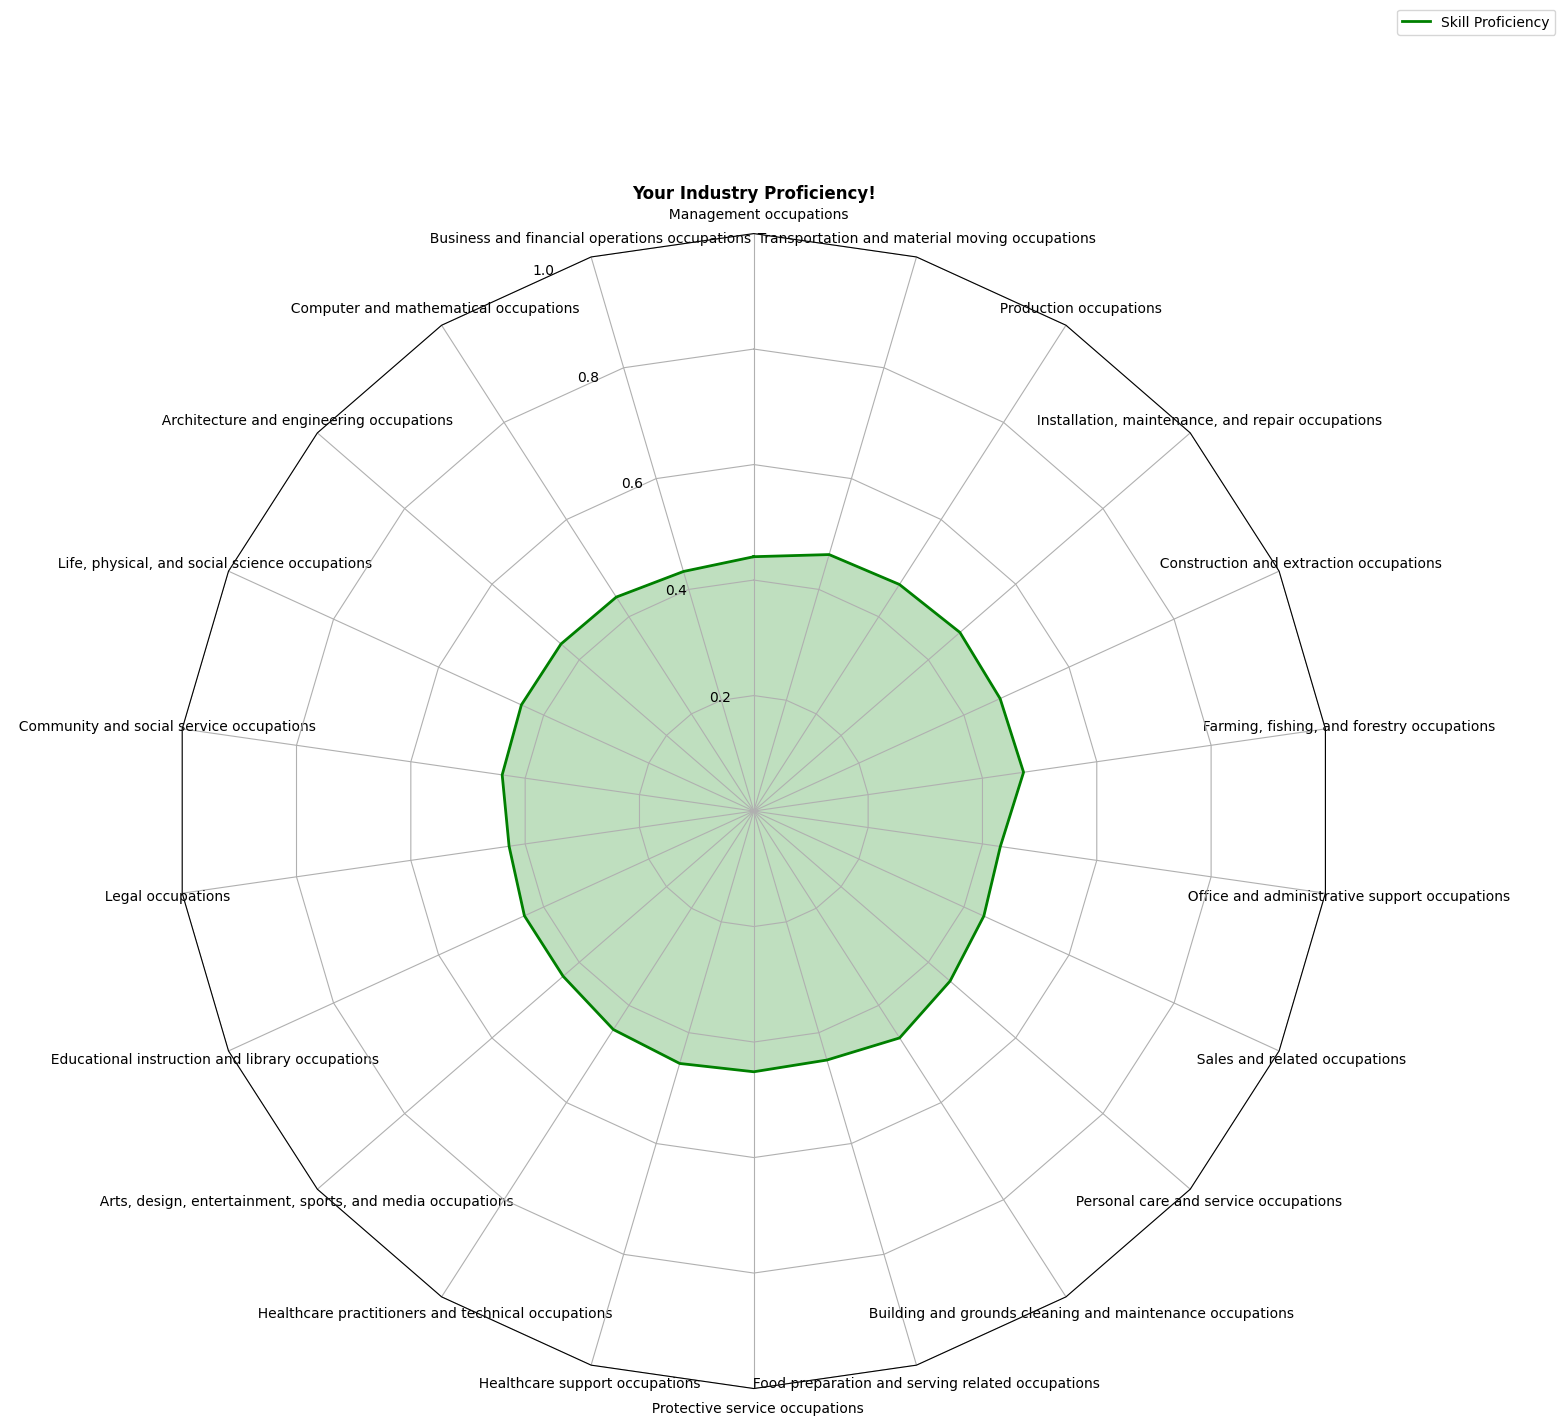

In [18]:
# Let's try visualizing now.

# Create the radar chart
n = len(group_names)  # Number of axes
theta = rf.radar_factory(n, frame='polygon')  # Generate the angles

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': 'radar'})
ax.set_title("Your Industry Proficiency!", weight='bold', size='large', position=(0.5, 1.1))

# Plot the data
ax.plot(theta, final_scores, color='g', linewidth=2, label='Skill Proficiency')
ax.fill(theta, final_scores, color='g', alpha=0.25)

# Set axis labels and limits
ax.set_varlabels(group_names)
ax.set_ylim(0, 1)  # Set the max value of each axis to 1

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))

# Display the chart
plt.show()